In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
from PIL import Image 
import time 

%matplotlib inline 

In [2]:
import utils as utils

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Prepare Dataset 

In [7]:
BATCH_SIZE = 32 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 8    # Shuffle the training data by a chunck of this many observations

In [8]:
filenames = utils.get_filenames_list('data/dataset128-easy-gaus/')
train_ds = utils.create_dataset(filenames, SHUFFLE_BUFFER_SIZE, AUTOTUNE, BATCH_SIZE)

# Model building - attempt 01 

## Architecture 

In [27]:
LATENT_DIM = 20

Model architecture from tf tutorials on MNIST dataset 

In [28]:
encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(128, 128, 1)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
        tf.keras.layers.Flatten(),
        # No activation
        tf.keras.layers.Dense(LATENT_DIM + LATENT_DIM) 
        ])


In [29]:
decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(LATENT_DIM,)),
        tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
        tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=4, padding='same',
            activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=4, padding='same',
            activation='relu'),
        # No activation
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same'),
        ])


In [30]:
decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              43008     
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 128, 128, 32)      18464     
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 128, 128, 1)       289       
Total params: 80,257
Trainable params: 80,257
Non-trainable params: 0
_________________________________________________________________


Utilities for VAE 

In [31]:
@tf.function
def sample(epsilon=None):
    """ Forward pass through second half of network.  Used for generating data samples.    
        Sample epsilon using tensorflow utilities 
    """
    if epsilon is None:
        epsilon = tf.random.normal(shape=(100, LATENT_DIM))
    return decode(epsilon, apply_sigmoid=True)



def encode(X): 
    """ Forward pass of encoder network 
    
        Input is data vector, X.  
    """
    mean, logvar = tf.split(encoder(X), num_or_size_splits=2, axis=1)
    return mean, logvar 


def reparameterize(mean, logvar):
    """ Forward pass through bottleneck section of network.  Outputs z vector.  
    """
    epsilon = tf.random.normal(shape=mean.shape)
    return epsilon * tf.exp(logvar * .5) + mean




def decode(z, apply_sigmoid=False): 
    """ Forward pass of decoder network.  
    
        Input is a sampled z vector 
    """
    logits = decoder(z) 
    
    if apply_sigmoid: 
        probs = tf.sigmoid(logits)
        return probs 
    return logits 
    

# Optimizer and loss 

In [32]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    """ Utility for ELBO.
    """
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(x, y): 
    """ Calculates model loss 
    """
    # Forward pass through the network 
    mean, logvar = encode(x)
    z = reparameterize(mean, logvar)
    x_logit = decode(z)
    
    # Calculate reconstruction loss (binary cross entropy)
    # Reconstruction loss will evaluate the similarity between inp and out. 
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y)
    
    # Calculate regularization portion (ELBO) 
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)
    

Training functions 

In [33]:
@tf.function
def train_step(x, y, optimizer):
    """Executes one training step and returns the loss.  

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    
    # Use GradientTape to record a computation graph 
    with tf.GradientTape() as tape:
        loss = compute_loss(x, y)
        
    # The tape is used to compute gradients using the computation graph 
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    
    return loss 


## Trainin' 

In [34]:
# train_size = 60000
batch_size = 32
# test_size = 10000


In [35]:
epochs = 10
num_examples_to_generate = 16

In [36]:
for epoch in range(1, epochs + 1):
    
    # tic
    start_time = time.time()
    
    for train_x, train_y in train_ds: 
        l = train_step(train_x, train_y, optimizer)

    print(l)
        
    
    # toc 
    end_time = time.time()

#     display.clear_output(wait=False)
#     print('Epoch: {}, time elapse for current epoch: {}'
#         .format(epoch, end_time - start_time))


tf.Tensor(11348.629, shape=(), dtype=float32)
tf.Tensor(11267.411, shape=(), dtype=float32)
tf.Tensor(10796.844, shape=(), dtype=float32)
tf.Tensor(10696.856, shape=(), dtype=float32)
tf.Tensor(10629.234, shape=(), dtype=float32)
tf.Tensor(10562.584, shape=(), dtype=float32)
tf.Tensor(10508.706, shape=(), dtype=float32)
tf.Tensor(10458.457, shape=(), dtype=float32)
tf.Tensor(10409.7705, shape=(), dtype=float32)
tf.Tensor(10377.299, shape=(), dtype=float32)


+ [x] training loop appears to work
+ [ ] build the random number seed thing in 

resuming...2020-10-24

# Testing 
Take and image, pass through network.

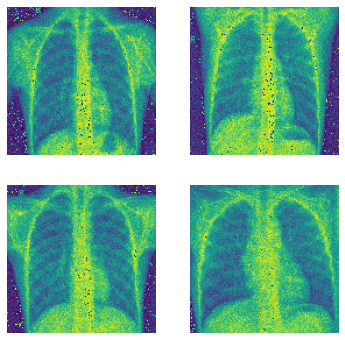

In [66]:
for i in train_ds.take(1): 
    ims = i[0]
    
    
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax = ax.reshape(-1) 

for i, ax in enumerate(ax): 
    ax.imshow(np.squeeze(ims[i]))
    ax.axis(False)

## Pass through network 

In [69]:
mean, logvar = encode(ims)
z = reparameterize(mean, logvar)
x_logit = decode(z)

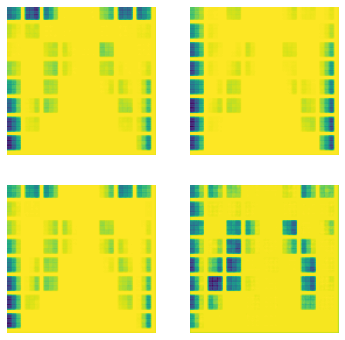

In [70]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax = ax.reshape(-1)

for i, ax in enumerate(ax):
    ax.imshow(np.squeeze(x_logit[i]))
    ax.axis(False)